In [1]:
import gc
import pandas as pd
import numpy as np
import sklearn as skl
import seaborn as sns
import lightgbm as lgb
import torch
import scipy
import opendatasets as od
import math
import torchmetrics
import utils.lgbm as lgbm
import importlib
import joblib
import category_encoders
import matplotlib.pyplot as plt
#Pipeline to train MLPs
import utils.mlp as mlp
import utils.mlp_pipeline as mlp_pipeline
import utils.embedding_pipeline as embedding_pipeline
from rtdl.rtdl import data as data
import pytorch_tabular

C:\Users\ritas\anaconda3\lib\site-packages\pytorch_tabular\models\mixture_density\mdn.py:25: UserWarning: Wandb not installed. WandbLogger will not work.
  warnings.warn("Wandb not installed. WandbLogger will not work.")


In [3]:
import pickle
import io

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)


In [10]:
#Function to calculate recall at FPR of rate

def find_optimal_recall(y_true,y_pred,rate):
    fpr,tpr,thresholds=skl.metrics.roc_curve(y_true,y_pred,drop_intermediate=False)
    optimal_index=np.argmin(abs(fpr-rate*np.ones(len(fpr))))
    return tpr[optimal_index]

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cpu device


In [5]:
#drive.mount('/content/gdrive')

In [15]:
#Kaggle api key: 9c2fc93aaaf8815d9fa8f2ceeeb57b6b
#od.download("https://www.kaggle.com/c/avazu-ctr-prediction/")

ctr_data=pd.read_csv("./avazu-ctr-prediction/train.gz",nrows=1000000)


In [4]:
embedding_pipeline=importlib.reload(embedding_pipeline)

In [16]:
X=ctr_data.loc[:,'C1':'C21']
Y=ctr_data.click

del ctr_data

    
training_range=range(0,math.floor(len(Y)*0.6))
validation_range=range(math.floor(len(Y)*0.6),math.floor(len(Y)*0.8))
testing_range=range(math.floor(len(Y)*0.8),math.floor(len(Y)*1))

#Establish continuous and categorical features
cat_cols=X.columns
cont_cols=X.columns.difference(cat_cols)


xtrain=X.loc[training_range]
ytrain=Y.loc[training_range]
xtest=X.loc[testing_range]
ytest=Y.loc[testing_range]
xval=X.loc[validation_range]
yval=Y.loc[validation_range]

x_train,x_test,x_val=embedding_pipeline.aggregate_low_card(xtrain,xtest,xval,cat_cols)

del X
del Y
gc.collect()

1996

In [8]:
cat_cols=xtrain.columns

# Parameter Tuning

In [ ]:
cat_cols=['C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id',
       'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model',
       'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18',
       'C19', 'C20', 'C21']

In [ ]:
import lgbm
aux=importlib.reload(lgbm)
param_list=lgbm.lgbm_param_sampler(20,7,'cpu')
print(len(param_list))
print(param_list[0])
i=0
for col in xtrain.select_dtypes(object).columns:
    print(col)
    le=skl.preprocessing.LabelEncoder()
    xtrain[col]=le.fit_transform(xtrain[col])
    xtest[col] = xtest[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
    xval[col] = xval[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, '<unknown>')
    xtest[col]=le.transform(xtest[col])
    xval[col]=le.transform(xval[col])
for col in xtrain.select_dtypes(float).columns:
    xtrain[col]=xtrain[col].fillna(np.average(xtrain[col]))
    xtest[col]=xtest[col].fillna(np.average(xtest[col]))
    xval[col]=xval[col].fillna(np.average(xtest[col]))

xtrain=xtrain.fillna(-1)
xtest=xtest.fillna(-1)
xval=xval.fillna(-1)

In [ ]:


max_auc=-10
for params in param_list:
    model = lgb.LGBMClassifier(n_jobs=10, **params)  # Instantiate LGBM Model.
        
    # Fit model to training data.
    model.fit(xtrain, ytrain,categorical_feature=cat_cols,eval_set=[(xval,yval)],early_stopping_rounds=5,eval_metric='loss',verbose=False)
    # Obtain predictions in test data.
    predictions = model.predict_proba(x_val)[:, 1]
    auc=skl.metrics.roc_auc_score(yval,predictions)
    if auc>max_auc:
        best_lgbm=model
        max_auc=auc
joblib.dump(best_lgbm,'LGBM_CTR/best_lgbm.pkl')

In [42]:
param_list=lgbm.lgbm_param_sampler(20,7,'cpu')

target_encoder=category_encoders.target_encoder.TargetEncoder(cols=cat_cols,handle_unknown='value',handle_missing='value')
catboost_encoder=category_encoders.cat_boost.CatBoostEncoder(cols=cat_cols,handle_unknown='value',handle_missing='value',drop_invariant=False,return_df=True,sigma=0)
count_encoder=category_encoders.count.CountEncoder(cols=cat_cols,verbose=0,handle_unknown='value',handle_missing='value',normalize=True,min_group_size=0.005,min_group_name='Leftover',combine_min_nan_groups=False)
enc=[catboost_encoder,count_encoder,target_encoder]
j=0
for encoding in ['cat','count','target']:
    encoder=enc[j]
    xtrain_aux=encoder.fit_transform(xtrain,ytrain)
    xval_aux=encoder.transform(xval)
    i=0
    for params in param_list:
        model = lgb.LGBMClassifier(n_jobs=10, **params)  # Instantiate LGBM Model.
        
        # Fit model to training data.
        model.fit(xtrain_aux, ytrain,eval_set=[(xval_aux,yval)],early_stopping_rounds=5,eval_metric='loss',verbose=False)
        joblib.dump(model,'LGBM_CTR/lgbm_{}{}'.format(encoding,i))
        i=i+1
    del xtrain_aux
    del xval_aux
    gc.collect()
    j=j+1

C:\Users\ritas\anaconda3\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\ritas\anaconda3\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserW

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserW

In [ ]:
best_lgbm=joblib.load('LGBM_CTR/best_lgbm.pkl')
predict= best_lgbm.predict_proba(xtest)[:, 1]

auc_lgb=skl.metrics.roc_auc_score(ytest,predict)
roc_lgb=skl.metrics.roc_curve(ytest,predict,drop_intermediate=False)
recall_lgb=find_optimal_recall(ytest,predict,0.05)

print(round(auc_lgb,5),'&',round(recall_lgb,5))

In [44]:
target_encoder=category_encoders.target_encoder.TargetEncoder(cols=cat_cols,handle_unknown='value',handle_missing='value')
catboost_encoder=category_encoders.cat_boost.CatBoostEncoder(cols=cat_cols,handle_unknown='value',handle_missing='value',drop_invariant=False,return_df=True,sigma=0)
count_encoder=category_encoders.count.CountEncoder(cols=cat_cols,verbose=0,handle_unknown='value',handle_missing='value',normalize=True,min_group_size=0.005,min_group_name='Leftover',combine_min_nan_groups=False)
enc=[catboost_encoder,count_encoder,target_encoder]
j=0
for encoding in ['cat','count','target']:
    encoder=enc[j]
    encoder=encoder.fit(xtrain,ytrain)
    xval_aux=encoder.transform(xval)
    xtest_aux=encoder.transform(xtest)
    max_auc=0
    for i in range(0,20):
        model=joblib.load("lgbm_3/lgbm_{}{}".format(encoding,i))
        predict=model.predict_proba(xval_aux)[:,1]
        auc=skl.metrics.roc_auc_score(yval,predict)
        if auc>max_auc:
            max_auc=auc
            best_model=model
    predict_test=best_model.predict_proba(xtest_aux)[:,1]
    auc=skl.metrics.roc_auc_score(ytest,predict_test)
    recall=find_optimal_recall(ytest,predict_test,0.05)
    print('LightGBM with ',encoding,' encoding: ',round(auc,5),round(recall,5))
    j=j+1

C:\Users\ritas\anaconda3\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\ritas\anaconda3\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


LightGBM with  cat  encoding:  0.75068 0.2126
LightGBM with  count  encoding:  0.7112 0.19341
LightGBM with  target  encoding:  0.73231 0.20192


# Categorical Encodings

In [30]:
cat_cols=xtrain.columns
cont_cols=xtrain.columns.difference(cat_cols)

target_encoder=category_encoders.target_encoder.TargetEncoder(cols=cat_cols,handle_unknown='value',handle_missing='value')
xtrain_encoded=target_encoder.fit_transform(xtrain,ytrain)
xval_encoded=target_encoder.transform(xval)

C:\Users\ritas\anaconda3\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\ritas\anaconda3\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


# CatBoost Encoder


In [ ]:
catboost_encoder=category_encoders.cat_boost.CatBoostEncoder(cols=cat_cols,handle_unknown='value',handle_missing='value',drop_invariant=False,return_df=True,sigma=0)
xtrain_cat=catboost_encoder.fit_transform(xtrain,ytrain)
xval_cat=catboost_encoder.transform(xval)

iteration:  0 Normalization: Median
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


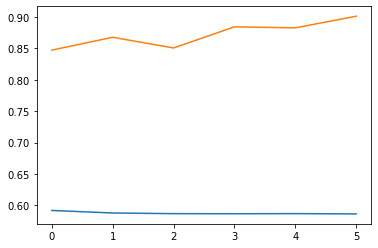

iteration:  1 Normalization: Median
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


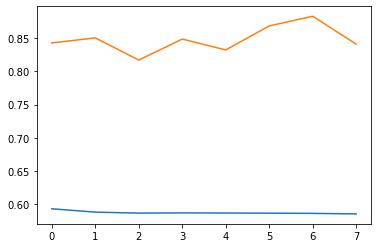

iteration:  2 Normalization: Median
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


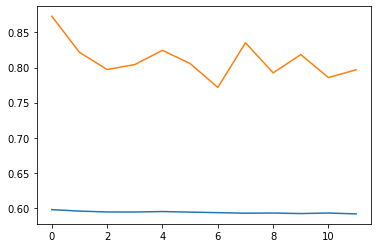

iteration:  3 Normalization: Median
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


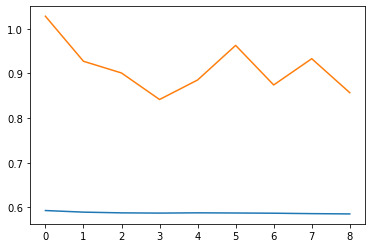

iteration:  4 Normalization: Median
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


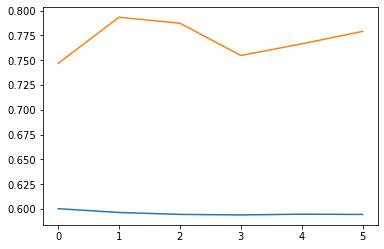

iteration:  5 Normalization: Median
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


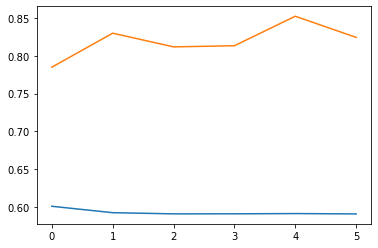

iteration:  6 Normalization: Median
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


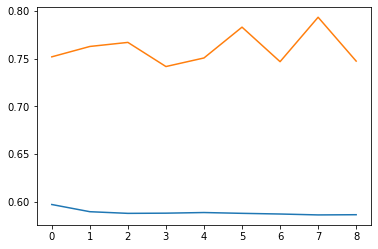

iteration:  7 Normalization: Median
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


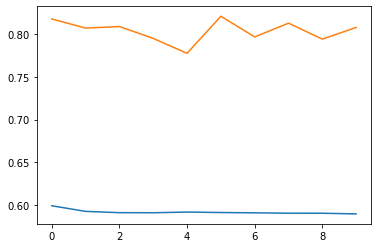

iteration:  8 Normalization: Median
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


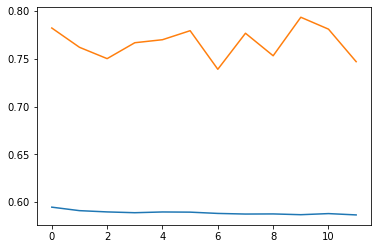

iteration:  9 Normalization: Median
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


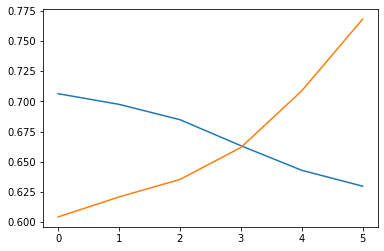

iteration:  10 Normalization: Median
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


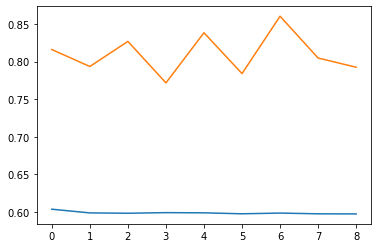

iteration:  11 Normalization: Median
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


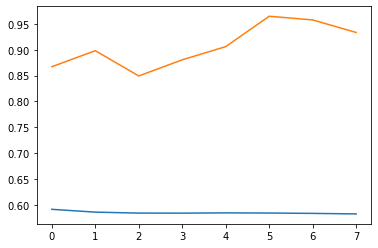

iteration:  12 Normalization: Median
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


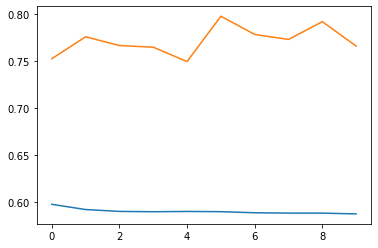

iteration:  13 Normalization: Median
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


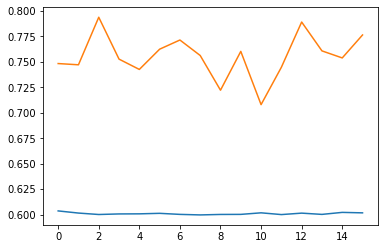

iteration:  14 Normalization: Median
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


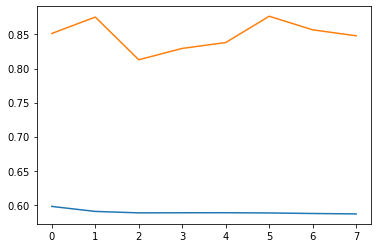

iteration:  15 Normalization: Median
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


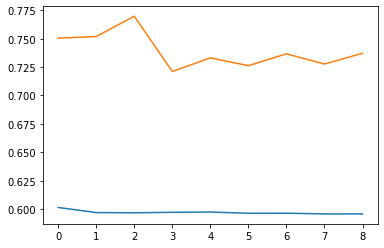

iteration:  16 Normalization: Median
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


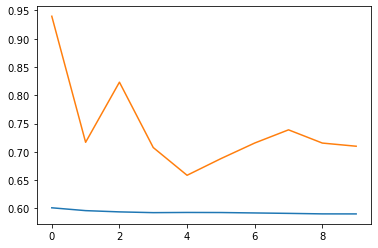

iteration:  17 Normalization: Median
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


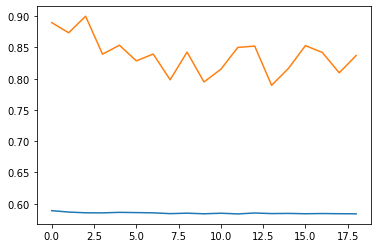

iteration:  18 Normalization: Median
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


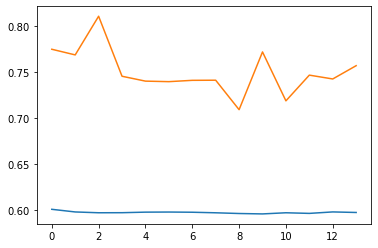

iteration:  19 Normalization: Median
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


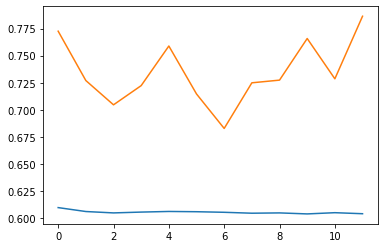

iteration:  0 Normalization: MinMax
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


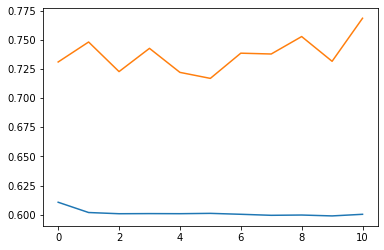

iteration:  1 Normalization: MinMax
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


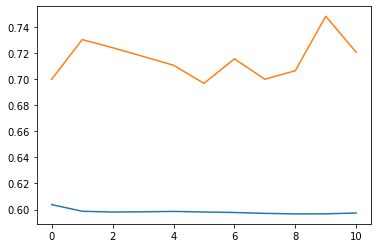

iteration:  2 Normalization: MinMax
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


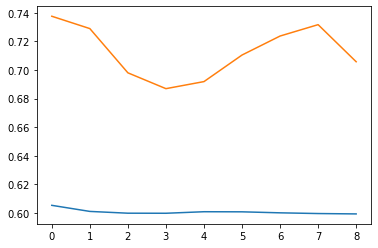

iteration:  3 Normalization: MinMax
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


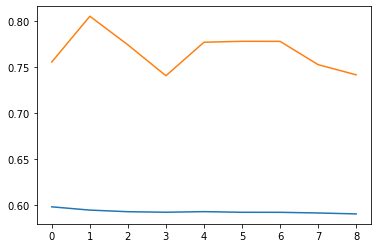

iteration:  4 Normalization: MinMax
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


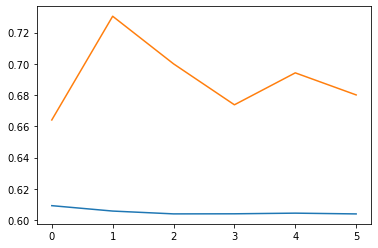

iteration:  5 Normalization: MinMax
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


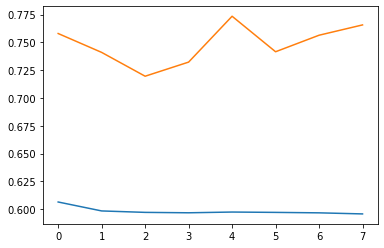

iteration:  6 Normalization: MinMax
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


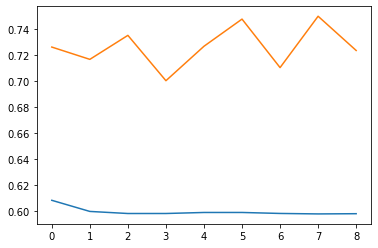

iteration:  7 Normalization: MinMax
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


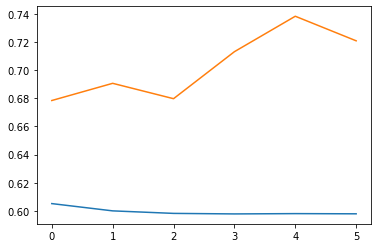

iteration:  8 Normalization: MinMax
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


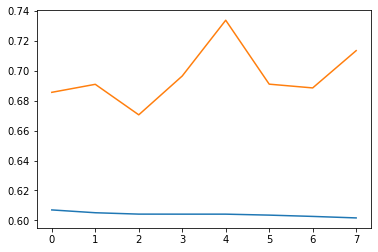

iteration:  9 Normalization: MinMax
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


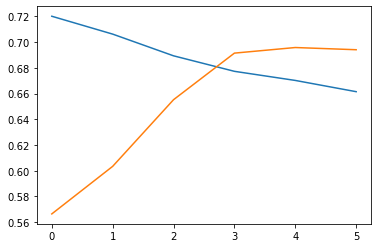

iteration:  10 Normalization: MinMax
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


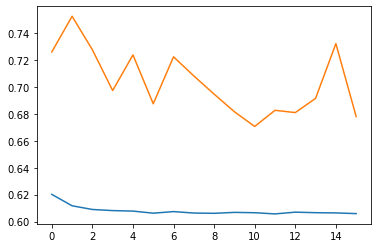

iteration:  11 Normalization: MinMax
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


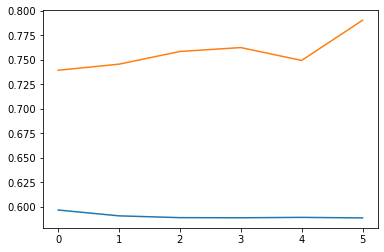

iteration:  12 Normalization: MinMax
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


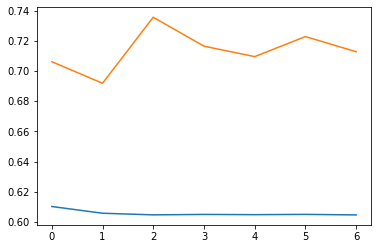

iteration:  13 Normalization: MinMax
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


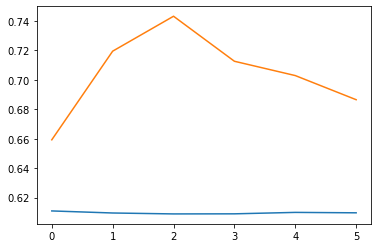

iteration:  14 Normalization: MinMax
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


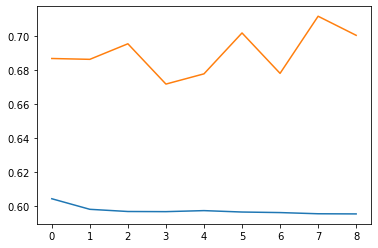

iteration:  15 Normalization: MinMax
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


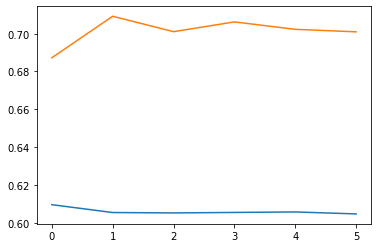

iteration:  16 Normalization: MinMax
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


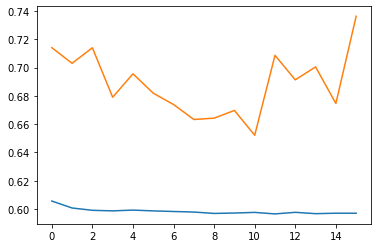

iteration:  17 Normalization: MinMax
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


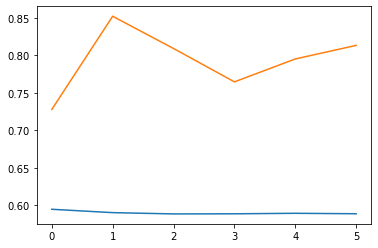

iteration:  18 Normalization: MinMax
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


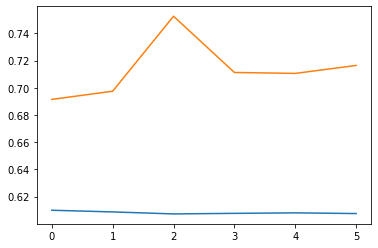

iteration:  19 Normalization: MinMax
----------Method:  None -------------
Train size:  600000 ; Number of 0:  501021 ; Number of 1: 98979
Val size:  200000 ; Number of 0:  170037 ; Number of 1: 29963
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


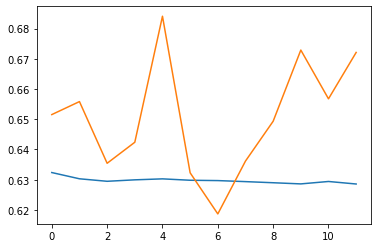

In [8]:


# Define number of trials in Random search.
n_trials=20

# Variable to store the results.
runs = {}
param_list=mlp.mlp_param_sampler(n_trials, len(xtrain.columns),7,device)



normalization=['None','Zscore','MinMax','Median']

for norm in normalization:
    xtrain_aux=mlp_pipeline.normalization_transform(xtrain_cat,norm,xtrain.columns)
    xval_aux=mlp_pipeline.normalization_transform(xval_cat,norm,xtrain.columns)
    i=0

    for params in param_list[i:]:
        # Fit pipeline
    
        print('iteration: ',i,'Normalization:',norm)
        
        model=mlp_pipeline.pipeline(device,xtrain_aux,xval_aux,ytrain,ytest,params,'None',cont_cols)

        #Save the model
        joblib.dump(model,'CTR_mlp/mlp_cat{}{}.pkl'.format(norm,i))

        i=i+1
    del xval_aux
    del xtrain_aux
    gc.collect()

In [13]:
target_encoder=category_encoders.target_encoder.TargetEncoder(cols=cat_cols,handle_unknown='value',handle_missing='value')
xtrain_aux=target_encoder.fit_transform(xtrain,ytrain)
xval_aux=target_encoder.transform(xval)

C:\Users\ritas\anaconda3\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\ritas\anaconda3\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [ ]:
import mlp
import mlp_pipeline
mlp_pipeline=importlib.reload(mlp_pipeline)

# Define number of trials in Random search.
n_trials=20


# Variable to store the results.
runs = {}
param_list=mlp.mlp_param_sampler(n_trials, len(xtrain.columns),7,device)

times=np.zeros(20)

normalization=['None','Zscore','MinMax','Median']

for norm in normalization:
    xtrain_aux=mlp_pipeline.normalization_transform(xtrain_aux,norm,xtrain.columns)
    xval_aux=mlp_pipeline.normalization_transform(xval_aux,norm,xtrain.columns)
    i=0

    for params in param_list[i:]:
        # Fit pipeline
    
        print('iteration: ',i,'Normalization:',norm)
        model=mlp_pipeline.pipeline(device,xtrain_aux,xval_aux,ytrain,ytest,params,'None',cont_cols)

        #Save the model
        joblib.dump(model,'CTR_mlp/mlp_final_target{}{}.pkl'.format(norm,i))
    
        i=i+1
    del xval_aux
    del xtrain_aux
    gc.collect()
    



In [35]:
count_encoder=category_encoders.count.CountEncoder(cols=cat_cols,verbose=0,handle_unknown='value',handle_missing='value',normalize=True,min_group_size=0.005,min_group_name='Leftover',combine_min_nan_groups=False)

xtrain_aux=count_encoder.fit_transform(xtrain,ytrain)
xval_aux=count_encoder.transform(xval)

In [ ]:


# Define number of trials in Random search.
n_trials=20

param_list=mlp.mlp_param_sampler(n_trials, len(xtrain.columns),7,device)



normalization=['None','Zscore','MinMax','Median']

for norm in normalization:
    xtrain_aux_temp=mlp_pipeline.normalization_transform(xtrain_aux,norm,xtrain.columns)
    xval_aux_temp=mlp_pipeline.normalization_transform(xval_aux,norm,xtrain.columns)
    i=0
    times=np.zeros(20)
    for params in param_list[i:]:
        # Fit pipeline
    
        print('iteration: ',i,'Normalization:',norm)
        model=mlp_pipeline.pipeline(device,xtrain_aux_temp,xval_aux_temp,ytrain,ytest,params,'None',cont_cols)
        #Save the model
        joblib.dump(model,'CTR_MLP/mlp_count{}{}.pkl'.format(norm,i))
        i=i+1
    del xval_aux_temp
    del xtrain_aux_temp
    gc.collect()

In [30]:
for i in range(14,20):
    if i==3 or i==12 or i==5 or i==13:
        print(i,' none')
    elif i>=4:
        file=open('tabtransformer_CTR/tabtransformerCTR_{}'.format(i),'rb')
        model=joblib.load(file)
        predict=model.predict(xval)['1_probability']
    else:
        model=joblib.load('tabtransformer_CTR/tabtransformerCTR_{}.pkl'.format(i))
        predict=model.predict(xval)['1_probability']
    auc=skl.metrics.roc_auc_score(yval,predict)
    recall=find_optimal_recall(yval,predict,0.05)
    
    if auc>max_auc:
        max_auc=auc
        best_model=model
        


C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Output()

C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Output()

C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Output()

C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Output()

C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Output()

C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Output()

In [31]:
predict_test=best_model.predict(xtest)['1_probability']
auc_test=skl.metrics.roc_auc_score(ytest,predict_test)
recall_test=find_optimal_recall(ytest,predict_test,0.05)

Output()

In [42]:
#First, let us look at the effects of normalization seperatly
auc_scores=np.zeros([4,4,20])
recall_scores=np.zeros([4,4,20])
k=0
enc=[catboost_encoder,count_encoder,target_encoder]
for encoding in ['cat','count','target']:
    j=0
    encoder=enc[j]
    xval_aux=encoder.transform(xval)
    for normalization in ['None','Zscore','MinMax','Median']:
        
        X_val_normalized=mlp_pipeline.normalization_transform(xval_aux,normalization,xval_aux.columns).float()
            
        for i in range(0,20):
            if encoding=='target' and (normalization=='MinMax' or normalization=='Median'):
                link="mlp_3/mlp_final_{}{}{}.pkl".format(encoding,normalization,i)
            else:
                link="mlp_3/mlp_{}{}{}.pkl".format(encoding,normalization,i)
            file = open(link,'rb')
            model = CPU_Unpickler(file).load()
            model.eval()
            predict = model(X_val_normalized)
            auc=skl.metrics.roc_auc_score(yval,predict.detach().numpy())
            roc=skl.metrics.roc_curve(yval,predict.detach().numpy(),drop_intermediate=False)
            recall=find_optimal_recall(roc[0],roc[1],roc[2],0.05)
            auc_scores[k][j][i]=auc
            recall_scores[k][j][i]=recall
        del X_val_normalized
        gc.collect
        j=j+1
    k=k+1
    

In [44]:
j=0
for encoding in ['cat','count','target']:

    param_list=mlp.mlp_param_sampler(20, len(xtrain.columns),7,device)
    xtest_aux=catboost_encoder.transform(xtest)
    norms= ['None','Zscore','MinMax','Median']
    
    encoder=enc[j]
    xtest_aux=encoder.transform(xtest)
    best_link=np.array(np.zeros([4,4]),dtype=object)
    for i in range(0,4):
        X_test_normalized=mlp_pipeline.normalization_transform(xtest_aux,norms[i],xtest.columns).float()        
        index=np.argmax(auc_scores[j][i])
        if encoding=='target' and (norms[i]=='MinMax' or norms[i]=='Median'):
            best_link[j][i]="mlp_3/mlp_final_{}{}{}.pkl".format(encoding,norms[i],index)
        else:
            best_link[j][i]="mlp_3/mlp_{}{}{}.pkl".format(encoding,norms[i],index)
        file = open(best_link[j][i],'rb')
        model = CPU_Unpickler(file).load()
        model.eval()
        predict = model(X_test_normalized)
        auc=skl.metrics.roc_auc_score(ytest,predict.detach().numpy())
        roc=skl.metrics.roc_curve(ytest,predict.detach().numpy(),drop_intermediate=False)
        recall=find_optimal_recall(roc[0],roc[1],roc[2],0.05)
        print(encoding,norms[i],'---',round(auc,5)," & ",round(recall,5))
        del X_test_normalized
        gc.collect
    j=j+1

cat None --- 0.73987  &  0.20916
cat Zscore --- 0.74299  &  0.20542
cat MinMax --- 0.73848  &  0.20419
cat Median --- 0.73298  &  0.20328
count None --- 0.66527  &  0.17812
count Zscore --- 0.66787  &  0.17171
count MinMax --- 0.67921  &  0.18413
count Median --- 0.61501  &  7e-05
target None --- 0.72991  &  0.19848
target Zscore --- 0.71782  &  0.22281
target MinMax --- 0.73869  &  0.20562
target Median --- 0.69828  &  0.1615


In [20]:
emb_auc=np.zeros(20)
emb_recall=np.zeros(20)

x_train,x_test,x_val=embedding_pipeline.aggregate_low_card_BAF(xtrain,xtest,xval,cat_cols)

xval_aux_cont=torch.tensor([])

xval_aux_cat=mlp_pipeline.normalization_transform(x_val,'None',[])
max_auc=0
for i in range(0,20):
    link='CTR_mlp/mlp_3_emb/mlp_simplevariational{}.pkl'.format(i)
    file = open(link,'rb')
    model = CPU_Unpickler(file).load()
    model.eval()
    predict = model(xval_aux_cont.float(),xval_aux_cat.long()).detach().numpy()
    auc=skl.metrics.roc_auc_score(yval,predict)
    recall=find_optimal_recall(yval,predict,0.05)
    emb_auc[i]=auc
    emb_recall[i]=recall
    if auc>max_auc:
        max_auc=auc
        best_model=model
        
xtest_aux_cont=torch.tensor([])
xtest_aux_cat=mlp_pipeline.normalization_transform(x_test,'None',[])
predict = model(xval_aux_cont.float(),xval_aux_cat.long()).detach().numpy()
auc=skl.metrics.roc_auc_score(yval,predict)
recall=find_optimal_recall(yval,predict,0.05)
print(round(auc,5),'&',round(recall,5))

0.73988 & 0.21022
